# Distortion test using the virtual 3D environment
In this test we are creating a virtual 3D points at 1m in the z axis and we fill the distorted image with these points, followed by undistortiing it with left and right camera and checking if the disparity is same across the whole region. 

In [1]:
import numpy as np
import depthai as dai
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    plt.figure(figsize=(12, 8))
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.imshow(image)


def display_overlay_points(left_pts, right_pts, markerSize = 20, setSize = True):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    if setSize:
        plt.xlim(0, size[0])
        plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()
    

# Getting calibration info

In [3]:
size = (1920, 1200)


calibration_handler = dai.CalibrationHandler('./calib_sensor_07.json')
M_left = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoLeftCameraId(), size[0], size[1]))
M_right = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoRightCameraId(), size[0], size[1]))
D_left = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoLeftCameraId()))
D_right = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoRightCameraId()))

transform = np.array(calibration_handler.getCameraExtrinsics(calibration_handler.getStereoRightCameraId(), calibration_handler.getStereoLeftCameraId())) 

left_rot_right = transform[:3, :3]
left_t_right = transform[:3, 3]
# Left is basically the origin here so
origin_rot_right = left_rot_right
origin_t_right = left_t_right
origin_rot_left = np.eye(3, dtype = np.float32)

R1 = np.array(calibration_handler.getStereoLeftRectificationRotation())
R2 = np.array(calibration_handler.getStereoRightRectificationRotation())

if 0:
    roll = 0
    pitch = 20 
    yaw = 0
    left_translation = np.array([5.0, 0.0, 0.0])
    rot_euler = R.from_euler('XYZ', [roll, pitch, yaw], degrees=True)
    cam_rot_matrix = rot_euler.as_matrix()
    
    rotation_matrix_4x4 = np.eye(4)
    rotation_matrix_4x4[:3, :3] = cam_rot_matrix
    rotation_matrix_4x4[0, 3] = left_translation[0]
    rotated_se3_matrix = transform @ rotation_matrix_4x4

    # Left is basically the origin here but rotated 20 deg. 
    origin_rot_right = rotated_se3_matrix[:3, :3]
    origin_t_right = rotated_se3_matrix[:3, 3]
    origin_rot_left = cam_rot_matrix
    
    origin_rvec_left, _ = cv2.Rodrigues(origin_rot_left)
    origin_rvec_right, _ = cv2.Rodrigues(origin_rot_right)
else:
    left_translation = np.array([0.0, 0.0, 0.0])

    origin_rvec_left, _ = cv2.Rodrigues(origin_rot_left)
    origin_rvec_right, _ = cv2.Rodrigues(origin_rot_right)

    # transform
    


M_focal = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(M_right, D_right, size, np.eye(3), fov_scale=1.1)
mapXL, mapYL = cv2.fisheye.initUndistortRectifyMap(M_left, D_left[:4], R1, M_focal, size, cv2.CV_32FC1)
mapXR, mapYR = cv2.fisheye.initUndistortRectifyMap(M_right, D_right[:4], R2, M_focal, size, cv2.CV_32FC1)

# display_overlay_points(reshaped_chess_corners_left[None], reshaped_chess_corners_right[None])


# Creating custom 3D points, distort them followed by undisort and check the alignment

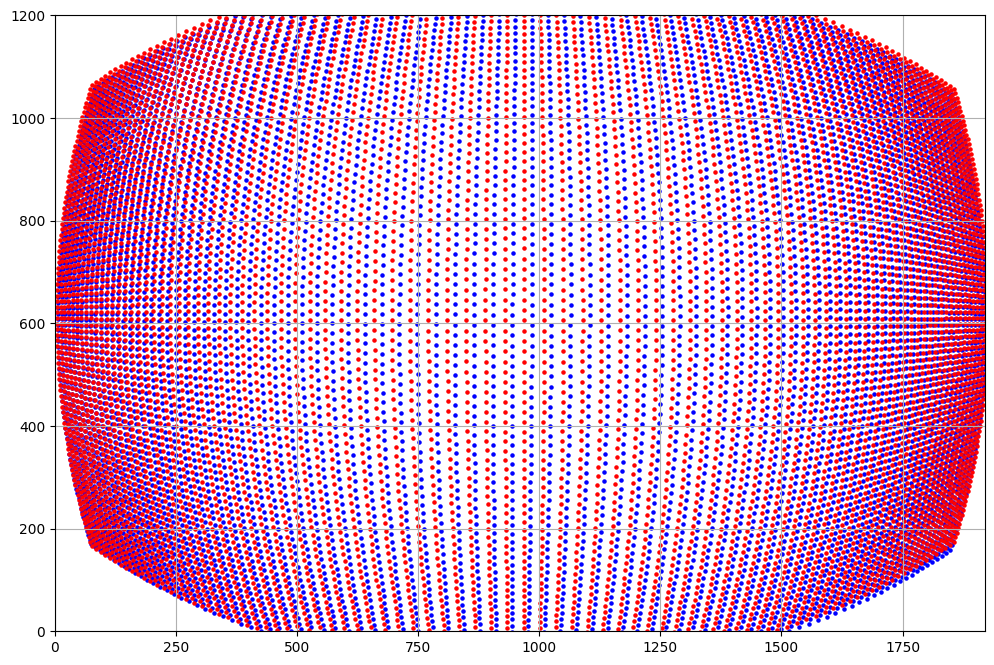

In [4]:
z_distance_cm = 300 #6m
x_range = z_distance_cm * 2
y_range = z_distance_cm
step_size = z_distance_cm * 0.3 * 1j
x, y = np.mgrid[-x_range : x_range : step_size, -y_range : y_range : step_size]
positions = np.vstack([x.ravel(), y.ravel()]).T
z_axis = np.ones((positions.shape[0], 1)) * z_distance_cm
points_3d = np.hstack([positions, z_axis])
points_3d = points_3d.astype(np.float32) @ origin_rot_right


left_points_2d, _ = cv2.fisheye.projectPoints(points_3d[None], origin_rvec_left, left_translation, M_left, D_left)

right_points_2d, _ = cv2.fisheye.projectPoints(points_3d[None], origin_rvec_right, origin_t_right, M_right, D_right)

display_overlay_points(left_points_2d, right_points_2d, 5)

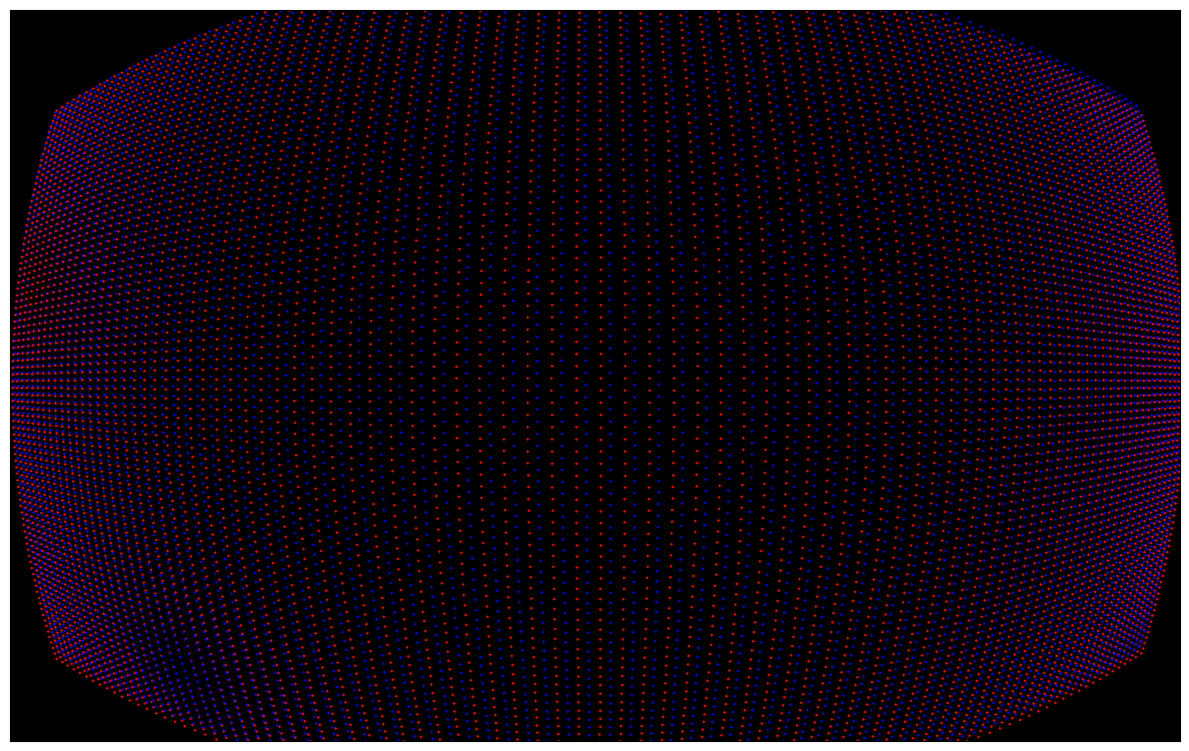

In [5]:
image = np.zeros((size[1], size[0], 3), dtype=np.uint8)
left_image = np.zeros((size[1], size[0], 3), dtype=np.uint8)
right_image = np.zeros((size[1], size[0], 3), dtype=np.uint8)

for i in range(left_points_2d.shape[1]):
    cv2.circle(image, (int(left_points_2d[0][i][0]), int(left_points_2d[0][i][1])), radius=2, color=(255, 0, 0), thickness=-1)  # -1 thickness means the circle will be filled
    cv2.circle(left_image, (int(left_points_2d[0][i][0]), int(left_points_2d[0][i][1])), radius=2, color=(255, 0, 0), thickness=-1)  # -1 thickness means the circle will be filled
    
    cv2.circle(image, (int(right_points_2d[0][i][0]), int(right_points_2d[0][i][1])), radius=2, color=(0, 0, 255), thickness=-1)  # -1 thickness means the circle will be filled
    cv2.circle(right_image, (int(right_points_2d[0][i][0]), int(right_points_2d[0][i][1])), radius=2, color=(0, 0, 255), thickness=-1)  # -1 thickness means the circle will be filled

show_rgb_image(image)

# It's time to undistort rectify the above black image

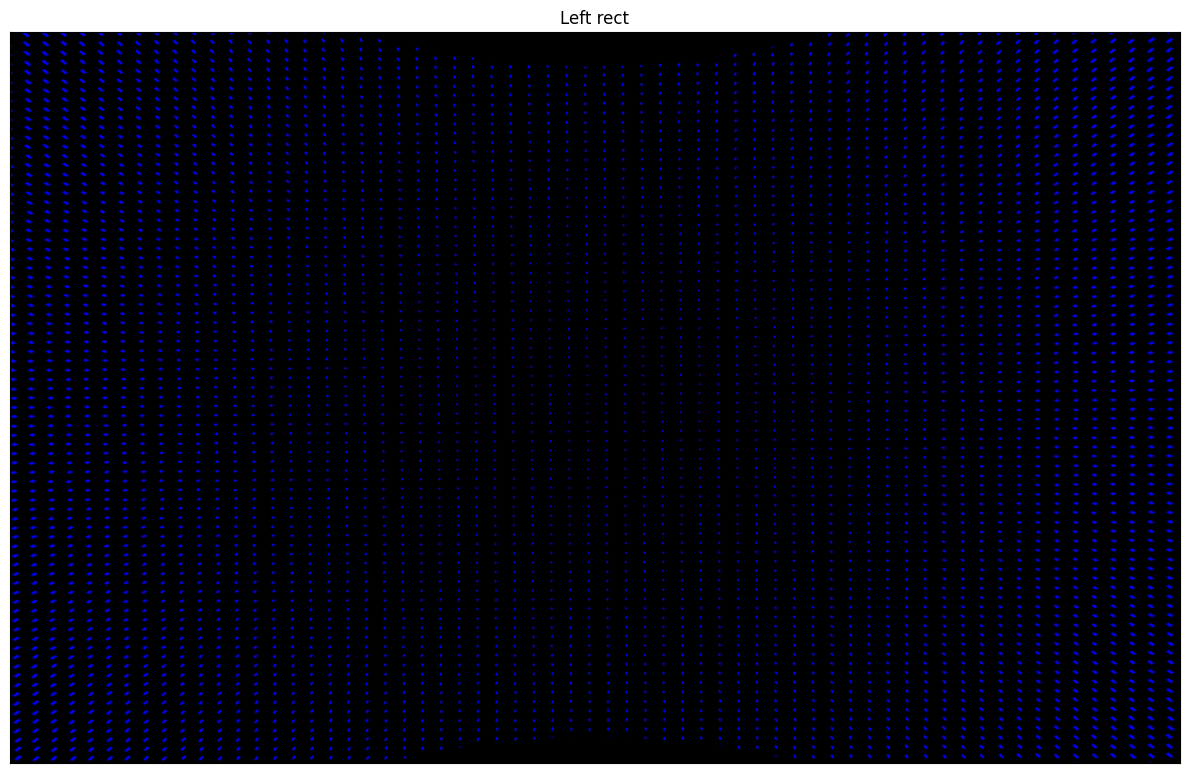

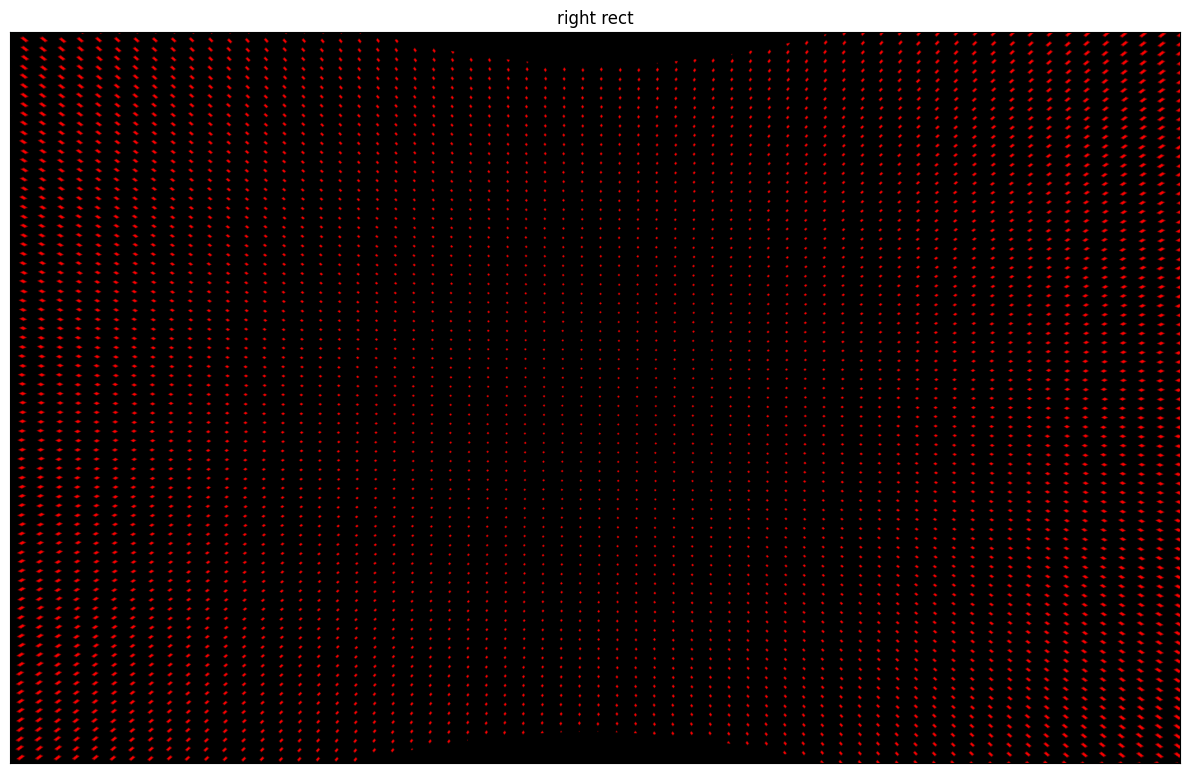

In [6]:
left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
show_rgb_image(left_rect, "Left rect")
show_rgb_image(right_rect, "right rect")

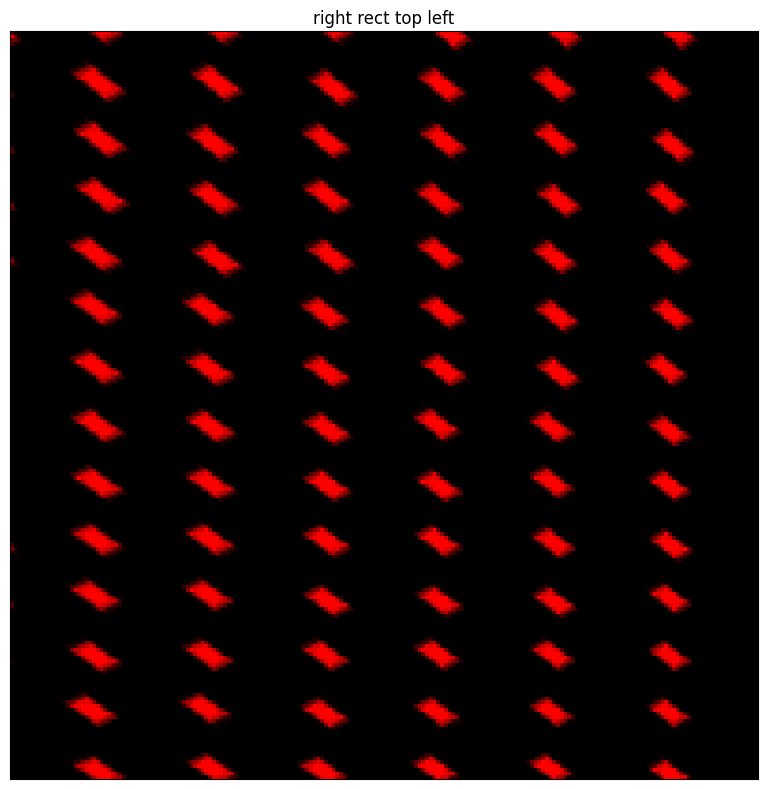

In [17]:
show_rgb_image(right_rect[:200, : 200], "right rect top left")

# Undistorting only the points to get the disparitys

(1, 8100, 2) (1, 8100, 2)


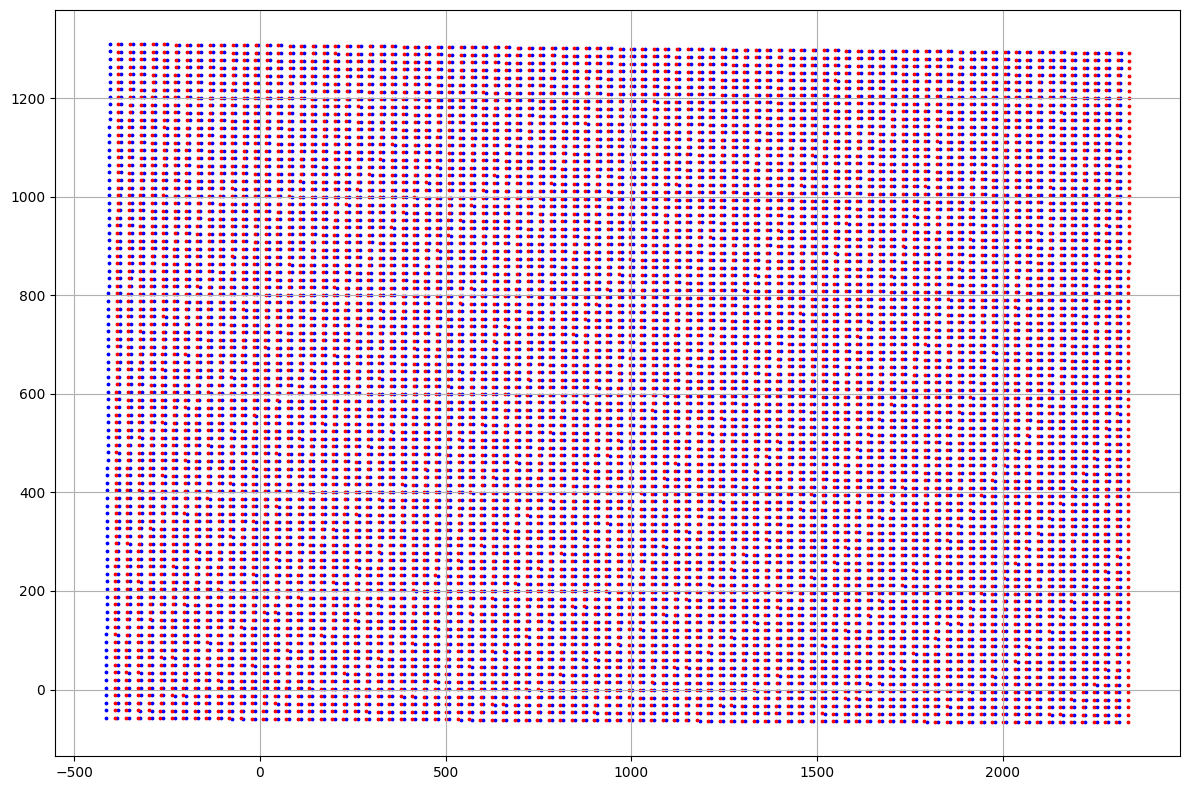

In [7]:
left_undistorted_points = cv2.fisheye.undistortPoints(left_points_2d, M_left, D_left, R = R1.T, P = M_focal)
right_undistorted_points = cv2.fisheye.undistortPoints(right_points_2d, M_right, D_right, R = R2.T, P = M_focal)

print(left_undistorted_points.shape, right_undistorted_points.shape)
display_overlay_points(left_undistorted_points, right_undistorted_points, 3, False)

# Calculate Disparity
- Calculate Disparity of the undistorted Points
- Plot the histogram
- Filter the non center disparity
- Check the depth at the center and the edges
- Display the non-center disparity points on the image. 

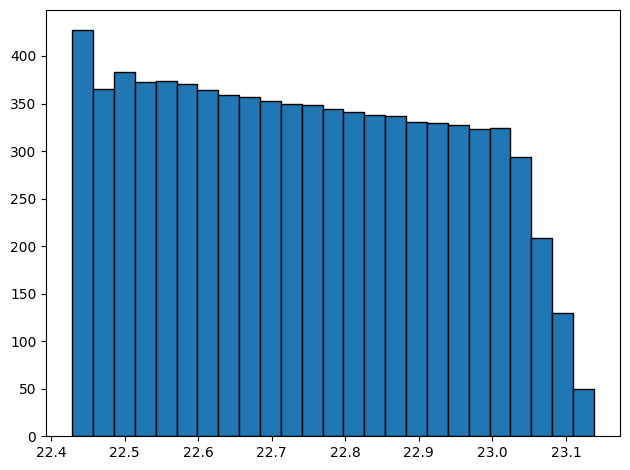

In [8]:
list_disparity = []
y_offsets = []
for i in range(right_undistorted_points.shape[1]):
    list_disparity.append(right_undistorted_points[0][i][0] - left_undistorted_points[0][i][0])
    y_offsets.append(right_undistorted_points[0][i][1] - left_undistorted_points[0][i][1])

list_disparity = np.array(list_disparity)
y_offsets = np.array(y_offsets)

plt.hist(list_disparity, bins=25, edgecolor='black')
plt.show()

In [9]:
right_undistorted_points

array([[[-391.35338864,  -57.67396774],
        [-391.23468142,  -42.26935639],
        [-391.11598153,  -26.86569507],
        ...,
        [2339.43870802, 1260.82661883],
        [2339.4728752 , 1276.04330882],
        [2339.50704029, 1291.25906935]]])

In [10]:
left_undistorted_points

array([[[-414.49140159,  -57.74922211],
        [-414.37144678,  -42.34101908],
        [-414.25149948,  -26.9337805 ],
        ...,
        [2317.00726871, 1261.01190947],
        [2317.04140229, 1276.23058759],
        [2317.07553375, 1291.44832232]]])

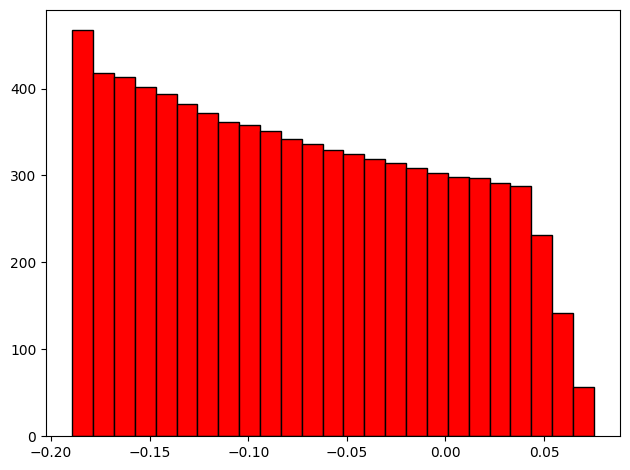

In [11]:
plt.hist(y_offsets, bins=25, edgecolor='black', color='red')
plt.show()

In [12]:
list_disparity.min()

22.42862749659571

In [13]:
def dispDepthConverter(disparity): # Does Disparity to Depth or Depth to disparity. 
    return left_t_right[0] * M_focal[0][0] / disparity

print(f'Expected Disparity Value -> {dispDepthConverter(z_distance_cm)}')
print(f'Depth at Min disparity value of {list_disparity.min()} is  Value -> {dispDepthConverter(list_disparity.min())} cm')
print(f'Depth at Min disparity value of {list_disparity.max()} is  Value -> {dispDepthConverter(list_disparity.max())} cm')
print(f'Accuracy at Min disparity value of {list_disparity.min()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity.min())) / z_distance_cm) * 100}%')
print(f'Accuracy at Min disparity value of {list_disparity.max()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity.max())) / z_distance_cm) * 100}%')

Expected Disparity Value -> 22.739754691815776
Depth at Min disparity value of 22.42862749659571 is  Value -> 304.16156354552623 cm
Depth at Min disparity value of 23.138012948169376 is  Value -> 294.83631212525825 cm
Accuracy at Min disparity value of 22.42862749659571 is  Value -> -1.387187848508745%
Accuracy at Min disparity value of 23.138012948169376 is  Value -> 1.721229291580585%


## Fitering bad disparities
#### Conditions for filtering are as follows

- 10 Disparities +/- of the one that matches
- Where the y offset is mroe or less than 5 pixels


## Display of points where disparitry is higher or lower

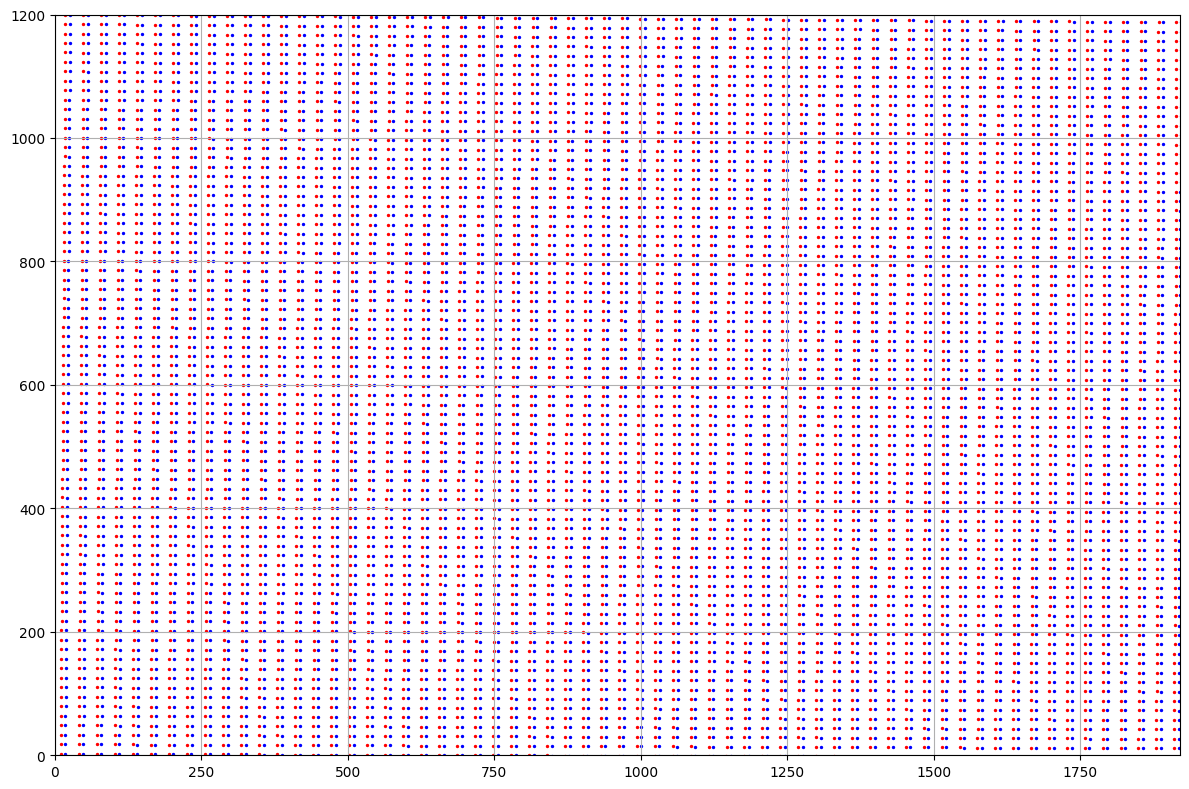

In [14]:
subIndex = np.where((list_disparity <  9) | (list_disparity >  11))
left_undistorted_points_edges = left_undistorted_points[0, subIndex ]
right_undistorted_points_edges = right_undistorted_points[0, subIndex ]

display_overlay_points(left_undistorted_points_edges, right_undistorted_points_edges, 2)

# Display of Points where Y offset is +/- 5

[]


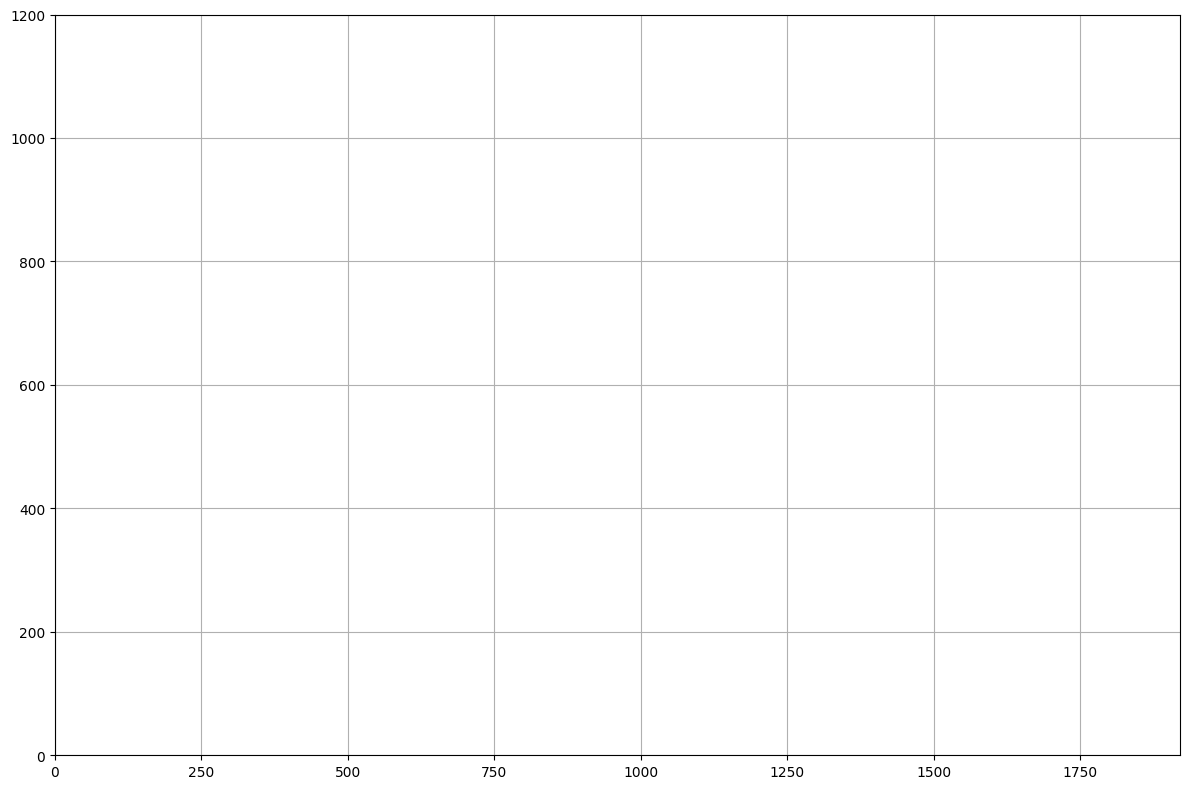

In [15]:
# indicies = np.where((y_offsets >  25) | (y_offsets <  -25))
indicies = np.where((y_offsets >  1) | (y_offsets <  -1))
left_undistorted_points_edges = left_undistorted_points[0, indicies ]
right_undistorted_points_edges = right_undistorted_points[0, indicies ]
print(y_offsets[indicies])
display_overlay_points(left_undistorted_points_edges, right_undistorted_points_edges, 1)

## Display of both in the above

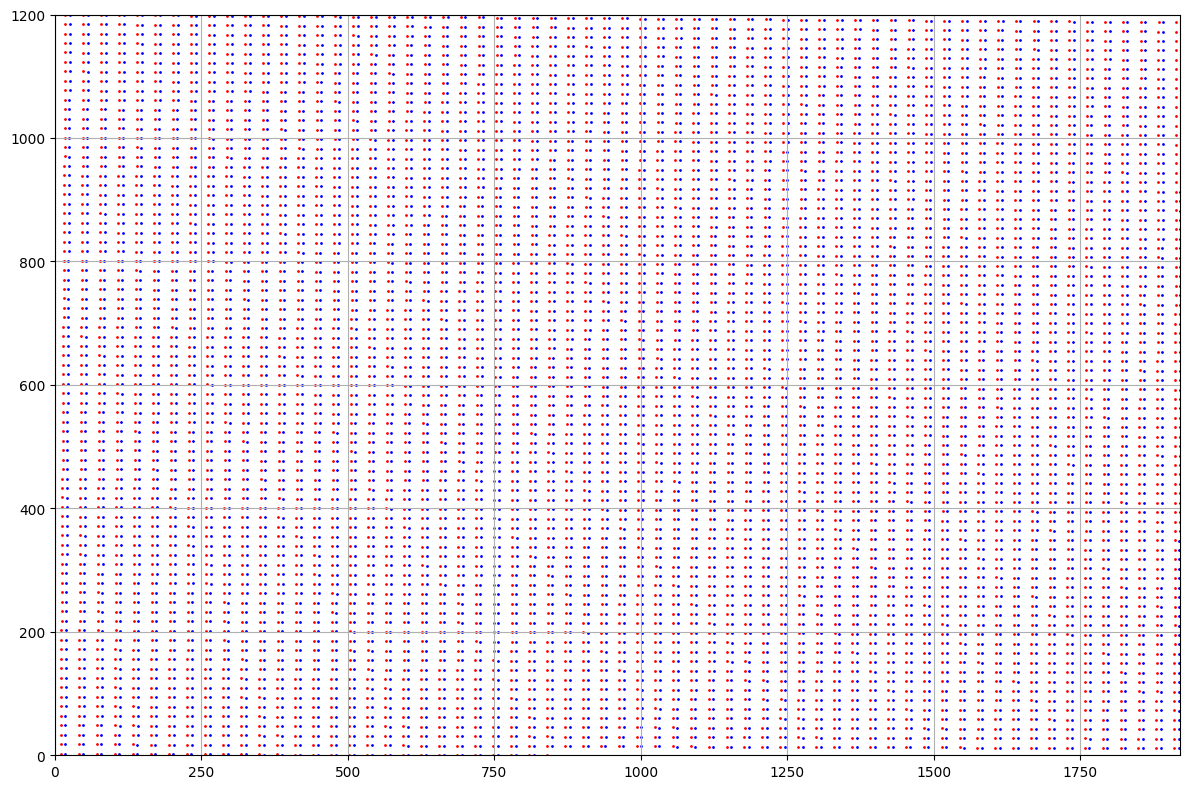

In [16]:
indicies = np.where((list_disparity <  50) | (list_disparity >  70) | (y_offsets >  5) | (y_offsets <  -5))
left_undistorted_points_edges = left_undistorted_points[0, indicies ]
right_undistorted_points_edges = right_undistorted_points[0, indicies ]

display_overlay_points(left_undistorted_points_edges, right_undistorted_points_edges, 1)